<a href="https://colab.research.google.com/github/MariaMora2723/PRACTICAS-S3-Y-S4/blob/main/Copia_de_TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

El siguiente comando sirve para descargar los datos que vamos a usar en la práctica.

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 228MB/s]


**1. Cargamos la extensión sql**

In [ ]:
%load_ext sql

**2. Nos conectamos con la base de datos**

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado?

In [ ]:
%%sql
SELECT status, count(*)
FROM LOAN
GROUP BY status
ORDER BY status

 * sqlite:///data_berka.db
Done.


status,count(*)
A,203
B,31
C,403
D,45


Podemos observar como los préstamos por estado son: 



*   Para el estado A: 203
*   Para el estado B: 31
*   Para el estado C: 403
*   Para el estado D: 45





Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0.


Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

A partir de acount accedemos a los datos demográficos. En primer lugar, se hace el join entre loan y account y después le indicamos que queremos los préstamos que se encuentren en estado A y B. 

La primera línea es para volcar todo en loans_train. 

Una nueva médida es el "INNER JOIN on" metido a través del FROM. 

El **CASE** es una forma a partir de diferentes casos de establecer diferentes valores de salida:
En este caso cuando sea A el resultado va a ser 1 y cuando sea B el resultado va a ser 0. 
Existe también meterle "else" para ponerle un valor alternativo. 

In [ ]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. **Obtenemos el DataFrame** 



Tenemos una tabla de aprendizaje supervisado, es decir, conformada por características, variables numéricas... 

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [ ]:
df_train.shape

(234, 7)

Para la parte de **test** lo que vamos a extraer de la base de datos son los préstamos que están en ejecución ("status in ("C", "D")) con los mismos campos que en la consulta anterior.

In [ ]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


**Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos adicionales.**


In [ ]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


**4. División de los datos en entrenamiento y test**

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

**Features** es una variable de tipo lista que me almacena los nombres de las características que me sirven como entrada. 

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


Ponemos como train (creación del modelo) los datos de préstamos ya finalizados y como test (evaluación del modelo) los datos de préstamos en ejecución. 

**5. Normalizarlos puede ser una buena medida para obtener mejores resultados.**
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


Al aplicar la tipificación, anula el efecto escala y eso hace mejorar nuestro modelo. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Se lleva a cabo un proceso de estandarización en el que se fija a los datos de entrenamiento y luego se aplica a datos de entrenamiento y de test.

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


**GaussianNB** sirve para variables continuas. 

**MultinomialNB** sirve para variables de frecuencias de valores enteros, y se usa mucho cuando se esta clasificando texto. 

El **BernoulliNB** es cuando las variables son binarias. 

El **ComplementNB** es una variante del multinomia pero para mejorar los resultados en problema de clasificación no balanceados. 

Se elige cualquiera de los 4, se entrena con el fit, y posteriormente se extraen las predicciones (probabilidad de clasificación de cada una de las clases) y se compara lo que se ha extraido del A y B con lo que se ha extraido del C y D. 

Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

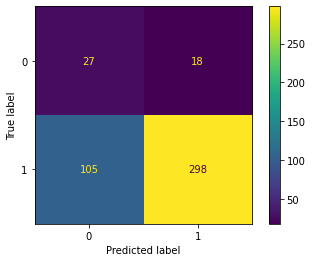

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

La matriz de confusión refleja en que nos estamos equivocando y en que estamos acertando. 
El eje de la Y refleja lo real y el eje de la X refleja lo que predecimos, con lo que: 

- Lo que esta en amarillo refleja lo que está verdaderamente pagado tanto en la realidad como en las predicciones. 

- En azul refleja lo que está verdaderamente pagado en la realidad pero no en la predicción. 

- En azulón refleja lo que no está verdaderamente pagado ni en la realidad ni en la predicción. 

- En morado refleja lo que no está verdaderamente pagado en la realidad pero si en la predicción. 

El problema en el resultado, al aplicar este clasificador de Naive Bayes, es que se pasa con los impagos (tiene 105 reales). 